# 0. Imports

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import xgboost as xgb

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score

# 1. Loading Data


In [2]:
df1 = pd.read_csv('./datasets/final_dataset/finished_dataset.csv')

In [3]:
df1 = df1.drop('Unnamed: 0', axis = 1)

In [4]:
df1.shape

(536, 48)

# 2. Data Types

In [5]:
df2 = df1.copy()

In [6]:
pd.DataFrame(df2.dtypes == 'object')

,0
Year,False
Datetime,True
Home Team Name,True
Away Team Name,True
Home Team Continent,True
Away Team Continent,True
Home_GDP,False
Home_POP,False
Home_INC,False
Away_GDP,False


In [7]:
df2['Datetime'] = pd.to_datetime(df2['Datetime'])

# 3. Checking NA

In [8]:
df3 = df2.copy()

In [9]:
df3.isna().sum()

Year                    0
Datetime                0
Home Team Name          0
Away Team Name          0
Home Team Continent     0
Away Team Continent     0
Home_GDP               13
Home_POP               12
Home_INC               21
Away_GDP               18
Away_POP               15
Away_INC               26
Home_RK                 1
Away_RK                 1
Home_Rating             1
Away_Rating             1
Home_AverageRank        1
Away_AverageRank        1
Home_AverageRating      1
Away_AverageRating      1
Home_YearRank           1
Away_YearRank           1
Home_YearRating         1
Away_YearRating         1
Home_MatchesTotal       1
Away_MatchesTotal       1
Home_MathcesHome        1
Away_MathcesHome        1
Home_MatchesAway        1
Away_MatchesAway        1
Home_MatchesNeutral     1
Away_MatchesNeutral     1
Home_MatchesWins        1
Away_MatchesWins        1
Home_MatchesLosses      1
Away_MatchesLosses      1
Home_MatchesDraws       1
Away_MatchesDraws       1
Home_GoalsFo

# 4. Correlations

In [10]:
df4 = df3.copy()

<AxesSubplot:>

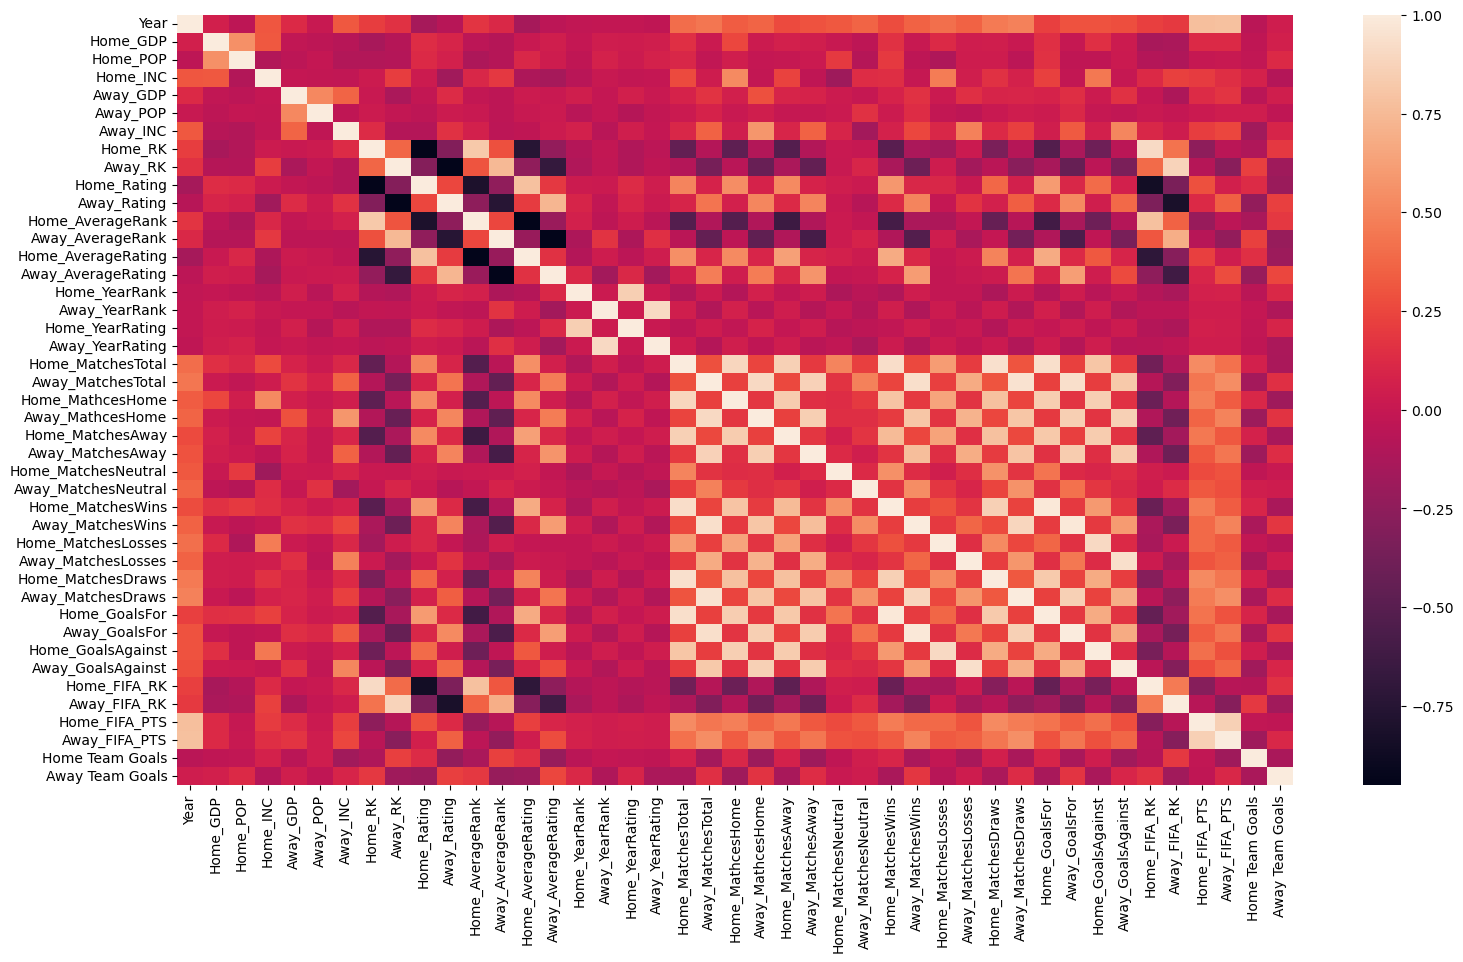

In [11]:
plt.figure(figsize=(18,10))
sns.heatmap(df4.corr())


# 5. Feature Engineering

## 5.1 Data Encoding

In [12]:
df5 = df4.copy()

In [13]:
df5 = pd.get_dummies(df5)

## 5.2 Features Creation

In [14]:
df5['Hour'] = df5['Datetime'].dt.hour
df5['Day of Year'] = df5['Datetime'].dt.day_of_year
df5['Month'] = df5['Datetime'].dt.month

In [15]:
df5['Hour'] = df5['Hour'].map({0: 15}).fillna(df5['Hour'])

In [16]:
df5 = df5.fillna(df5.mean())

/var/folders/jv/cy7t95qj2rsfb63lnq4ctt1w0000gn/T/ipykernel_27118/2566851418.py:1: FutureWarning: DataFrame.mean and DataFrame.median with numeric_only=None will include datetime64 and datetime64tz columns in a future version.
  df5 = df5.fillna(df5.mean())


In [17]:
df5.loc[df5['Year'] == 2022, 'Home Team Goals'] = np.nan
df5.loc[df5['Year'] == 2022, 'Away Team Goals'] = np.nan


# 6. Feature Selection and DataFrame Split

In [18]:
df6 = df5.copy()

In [19]:
df6_before = df6[df6.Year < 2022]
df6_2022 = df6[df6.Year == 2022]

In [20]:
df6.shape

(536, 221)

In [21]:
df6_before.shape

(488, 221)

In [22]:
df6_2022.shape

(48, 221)

In [23]:
features_to_drop = ['Datetime', 'Year']

In [24]:
df6_before = df6_before.drop(features_to_drop, axis=1)
df6_2022 = df6_2022.drop(features_to_drop, axis=1)

In [25]:
target = ['Home Team Goals', 'Away Team Goals']
X_before = df6_before.drop(target, axis=1)
y_before = df6_before[target]

In [26]:
X_2022 = df6_2022.drop(target, axis=1)

In [27]:
y_before

,Home Team Goals,Away Team Goals
0,2.0,2.0
1,1.0,0.0
2,1.0,1.0
3,0.0,1.0
4,1.0,3.0
...,...,...
531,2.0,0.0
532,0.0,1.0
533,0.0,1.0
534,2.0,2.0


## 6.1 Split DataFrame in Train and Test 

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_before, y_before, random_state=42)

## 7. Machine Learning Modeling

In [29]:
# helper function to check the winner
def check_result(row):
    if row['Home Team Goals'] > row['Away Team Goals']:
        return 1
    elif row['Home Team Goals'] < row['Away Team Goals']:
        return 2
    else:
        return 0

In [30]:
y_test_victory = y_test.copy()
y_test_victory['Result'] = y_test.apply(check_result, axis=1)

In [31]:
model = xgb.XGBRegressor()
model.fit(X_train, y_train)
y_pred = np.round(model.predict(X_test))

In [32]:
y_pred_victory = pd.DataFrame(y_pred, columns=['Home Team Goals', 'Away Team Goals'])
y_pred_victory['Result'] = y_pred_victory.apply(check_result, axis=1)

In [33]:
f1_score(y_test_victory['Result'].values, y_pred_victory['Result'].values, average=None)

array([0.24691358, 0.44210526, 0.38235294])

In [34]:
accuracy_score(y_test_victory['Result'].values, y_pred_victory['Result'].values)

0.36065573770491804

In [35]:
precision_score(y_test_victory['Result'].values, y_pred_victory['Result'].values, average=None)

array([0.2173913 , 0.48837209, 0.39393939])

## 8.0 Fine Tuning

In [36]:
params = {
    'n_estimators': [1500, 1700, 2500], # 3000, 3500],
    'eta': [0.01, 0.03],
    'max_depth': [3, 5, 9],
    'subsample': [0.1, 0.5, 0.9],
    'colsample_bytree': [0.2, 0.5, 0.9],
    'min_child_weight': [3, 8, 15]    
}

In [37]:
cv = KFold(n_splits=5)
random_search = RandomizedSearchCV(xgb.XGBRegressor(random_state=42), params, scoring=['neg_mean_squared_error', 'neg_root_mean_squared_error'], refit='neg_mean_squared_error',  n_iter=1000, cv=cv, n_jobs=-1)

results = random_search.fit(X_train, y_train)

/Users/mahelvson/opt/anaconda3/envs/worldcup/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 486 is smaller than n_iter=1000. Running 486 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


In [51]:
results.best_score_

-1.4021231578196842

In [52]:
results.best_params_

{'subsample': 0.1,
 'n_estimators': 1500,
 'min_child_weight': 15,
 'max_depth': 3,
 'eta': 0.01,
 'colsample_bytree': 0.2}

# 9. Final Model

In [40]:
final_model = xgb.XGBRegressor(random_state=42, subsample= 0.1,
                                                n_estimators= 1500,
                                                min_child_weight= 15,
                                                max_depth= 3,
                                                eta= 0.01,
                                 
                                                colsample_bytree= 0.2)
final_model.fit(X_train, y_train)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=15,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

# 9.1 Validation

In [41]:
y_pred_test = np.round(final_model.predict(X_test))

In [42]:
y_pred_victory = pd.DataFrame(y_pred_test, columns=['Home Team Goals', 'Away Team Goals'])
y_pred_victory['Result'] = y_pred_victory.apply(check_result, axis=1)

In [43]:
f1_score(y_test_victory['Result'].values, y_pred_victory['Result'].values, average='weighted')

0.41869400155414704

In [44]:
accuracy_score(y_test_victory['Result'].values, y_pred_victory['Result'].values)

0.4098360655737705

In [45]:
precision_score(y_test_victory['Result'].values, y_pred_victory['Result'].values, average='weighted')

0.44739633558341374

## 9.2 World Cup Forecasting

In [46]:
final_model = xgb.XGBRegressor(random_state=42, subsample= 0.1,
                                                n_estimators= 1500,
                                                min_child_weight= 15,
                                                max_depth= 3,
                                                eta= 0.01,
                                                colsample_bytree= 0.2)
final_model.fit(X_before, y_before)


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.2,
             early_stopping_rounds=None, enable_categorical=False, eta=0.01,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.00999999978,
             max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=3, max_leaves=0, min_child_weight=15,
             missing=nan, monotone_constraints='()', n_estimators=1500,
             n_jobs=0, num_parallel_tree=1, predictor='auto', ...)

In [47]:
y_2022 = np.round(final_model.predict(X_2022))

In [48]:
df_results = pd.concat([df4[df4['Year'] == 2022][['Home Team Name', 'Away Team Name']].reset_index(), pd.DataFrame(y_2022, columns=['Home Team Goals', 'Away Team Goals'])], axis=1, ignore_index=True)
df_results.columns = ['Index', 'Home Team Name', 'Away Team Name', 'Home Team Goals', 'Away Team Goals']

In [49]:
df_results = df_results.drop('Index', axis=1)

In [50]:
df_results

,Home Team Name,Away Team Name,Home Team Goals,Away Team Goals
0,Qatar,Ecuador,1.0,1.0
1,Senegal,Netherlands,1.0,2.0
2,England,"Iran, Islamic Rep.",2.0,1.0
3,United States,Wales,1.0,1.0
4,France,Australia,2.0,1.0
5,Denmark,Tunisia,2.0,1.0
6,Mexico,Poland,1.0,1.0
7,Argentina,Saudi Arabia,2.0,1.0
8,Belgium,Canada,2.0,1.0
9,Spain,Costa Rica,2.0,1.0
